# EELS SrFeO Project 
## Data Preparation
> **PCA and t-SNE are also attempted in this notebook**

*Collaboration: M3 Learning at Lehigh University x Dynamic Characterization Group at Drexel University*

September 2019:
> The data provided includes initial state (SrFeO3 with Fe4+) and annealed state (SrFeO2.5 with Fe3+). Total of 90,000 spectra was provided: 
- 2 sets of 10 spectrum images with 300 x 30 spatial coordinates. 
- Each spatial coordinate has 3710 energy channels. 
- For each spectra, the initial energy-loss value is 387.5 eV with energy width of 0.125 eV.
- i.e. \[387.5: 851.25: 0.125\]


### Import Package

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import hyperspy.api as hs
import numpy as np
import pandas as pd
import scipy
import itertools
hs.preferences.GUIs.warn_if_guis_are_missing = False

### Loading Data

Avoid stacking because you will lose access to multi-files metadata

In [3]:
# Loading Initial Data

data_initial = hs.load('temporal_data/High-Speed EELS/Initial SIs/*.dm4', stack=False)
#print(data_initial.metadata)
#print(data_initial.axes_manager)

In [4]:
# Loading Annealed Data

data_anneal = hs.load('temporal_data/High-Speed EELS/annealed SIs/*.dm4', stack=False)
#print(data_initial.metadata)
#print(data_initial.axes_manager)

### Dark reference
Software used to collect EELS data has some glitches. Dark reference is provided and must be added to each spectrum.

In [5]:
def add_dark_ref(stacked_data, dark_ref):
    """
    Add dark references to EELS dataset
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)
    dark_ref: 1d array
        dark reference for correction
    """
    dim = stacked_data[0].data.shape
    for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
        stacked_data[k].data[i][j] = np.sum([stacked_data[k].data[i][j],dark_ref.data], axis=0)

In [6]:
# Add dark references

dark_ref = hs.load('temporal_data/High-Speed EELS/dark reference.dm4', signal_type="EELS")
add_dark_ref(data_initial, dark_ref)
add_dark_ref(data_anneal, dark_ref)

### Background Subtraction 

Jamie suggested performing background subtraction based on power law fit. $I = A*E^r$
* I is the measured intensity, 
* A is a constant
* E is the energy-loss value (eV)
* r is an exponent (usually around 3)

Select an energy window (around 50 eV wide) at around a few eV before the region of interest to fit A and r.

#### Resources
https://github.com/trygvrad/RNN-on-EELS-data/blob/master/EELScodes \
https://scipy-cookbook.readthedocs.io/items/FittingData.html \
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [7]:
'''
Background Subtraction & Filter noise (Savizky-Golay Filter)
'''
import scipy.optimize # curve_fit
from scipy.fftpack import fft

def scaledExp(x,a,b):
    return a*np.exp((np.array(x))*b)

def subtractExpBackground(data1,xrange=None):
    data2 = np.float32(np.copy(data1))
    x = range(data1.shape[2])
    # fit over the entire spectra by default
    if type(xrange) == type(None):
        xrange = x 
    for i in range(data1.shape[0]):
        for j in range(data1.shape[1]):
            popt, pcov = scipy.optimize.curve_fit(scaledExp,xrange,data2[i,j,xrange], p0 = [4.19082741e+02, -1.93625569e-03])
            data2[i,j] = data2[i,j]-scaledExp(x,popt[0],popt[1])
            # print(popt)
    return data2

def subtract_bckgrnd_and_filter(data):
    backgroundregion = np.arange(400,1000,1)  # this is approximately 50eV wide, over the region before ROI
    for k,spectra in enumerate(data): 
        data[k].data = subtractExpBackground(spectra.data,backgroundregion)

In [8]:
subtract_bckgrnd_and_filter(data_initial)
subtract_bckgrnd_and_filter(data_anneal)

### Savitzky–Golay Noise Filter

In [9]:
def filter_savgol(stacked_data):
    """
    Apply Savitzky–Golay filter to reduce noise
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)
    """
    for k,spectra in enumerate(stacked_data):
        # Savitzky–Golay filter with window size 51, polynomial order 3
        stacked_data[k].data = scipy.signal.savgol_filter(stacked_data[k].data, 51, 3) # window size 50, polynomial order 3

In [10]:
# Apply SavGol filter

filter_savgol(data_initial)
filter_savgol(data_anneal)

### Fast Fourier Transform 

You can plot this out. What you will see in this dataset however is that there is no real patterns of noise that must be removed i.e. after doing FTT, you may be able to pick out certain features in the graph that may correspond to noise to be removed.

>"The output of the FFT is a complex vector containing information about the frequency content of the signal. The magnitude tells you the strength of the frequency components relative to other components. The phase tells you how all the frequency components align in time." ~ Mathworks.com

### Cropping spectral image

(30, 300)


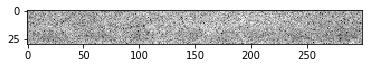

In [11]:
# Visualizing cropped area
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

cropped = np.average(data_initial[3].data[:], axis=(2))
print(cropped.shape)

fig, ax = plt.subplots()
im = ax.imshow(cropped)

In [12]:
# window is y = [7:35]
def crop(data):
    for k,sp in enumerate(data):
        data[k].data = sp.data[7:35]
        print(str(k)+": "+str(data[k].data.shape))

In [13]:
#crop(raw_data)

### Downsampling

Done to reduce data size.

#### Resources
https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.downscale_local_mean

In [14]:
from scipy.signal import resample

def downsample(stacked_data, N_resampled:int):
    """
    down sampling the data
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    N_resampled: int
        number of samples in the resampled set
    """
    dim = stacked_data[0].data.shape
    if N_resampled != dim[2]: 
        for k,sp in enumerate(stacked_data):
            stacked_data[k].resample = np.zeros((dim[0],dim[1], N_resampled))
        for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
            stacked_data[k].resample[i][j] = resample(stacked_data[k].data[i][j][:], N_resampled) 
    else:
        for k,sp in enumerate(stacked_data):
            stacked_data[k].resample = np.zeros((dim[0],dim[1], dim[2]))
        for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
            stacked_data[k].resample[i][j] = stacked_data[k].data[i][j][:]

In [15]:
data_initial[0].data.shape

(30, 300, 3710)

In [18]:
N_resampled = 1500
#N_resampled = data_initial[0].data.shape[2]

downsample(data_initial, N_resampled)
downsample(data_anneal, N_resampled)

### Visualize aggregated signals

Visualizing what we would expect from combined signals. This is just a quality assurance that we didn't do something real wrong. Signals should look smooth and pretty when SNR is high!

Text(0, 0.5, 'counts')

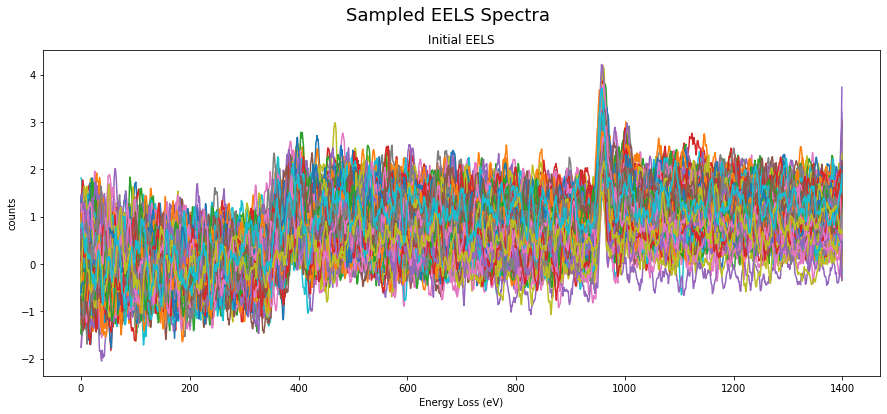

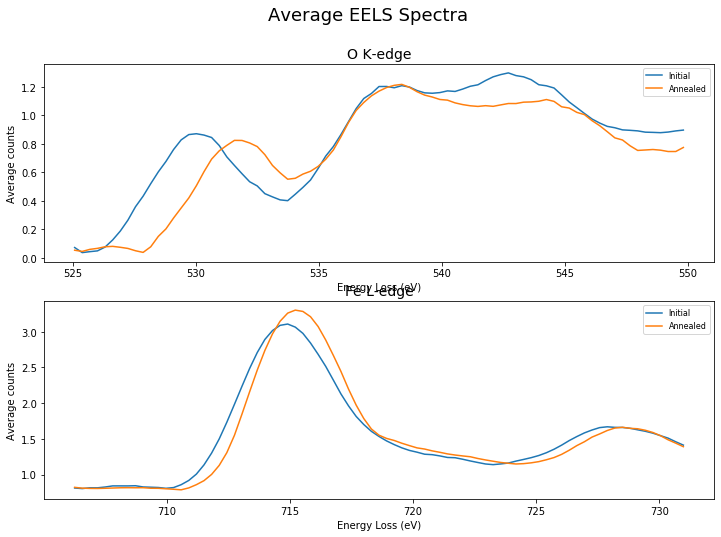

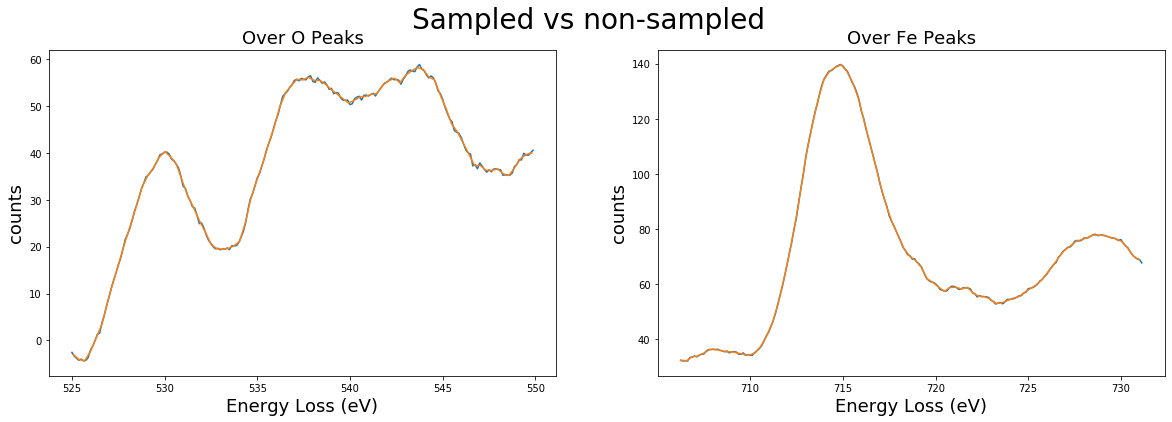

In [44]:
# visualizing raw data

import math

start = 387.5 #eV
stop = 851.25 #eV
step = 0.125 #eV
o_r = (1100,1300)
fe_r = (2550,2750)

frac = N_resampled/data_initial[0].data.shape[2]
O_range = range(math.ceil(o_r[0]*frac),math.ceil(o_r[1]*frac),1)
Fe_range = range(math.ceil(fe_r[0]*frac),math.ceil(fe_r[1]*frac),1)
O_xrange = [start+step*i/frac for i in O_range]
Fe_xrange = [start+step*i/frac for i in Fe_range]

# Plotting individual spectrum
f,(ax1) = plt.subplots(1, figsize=(15,6))
# initial data on image 3, [20,:,400:2500]
for i in data_initial[3].resample[20]:
    ax1.plot(i[100:3000])
# plotting individual anneal data on image 3, [20,:,400:2500]
#for i in data_anneal[3].resample[20]:
#    ax2.plot(i[100:300])

# Plotting averaged spectra 
g,(ax3,ax4) = plt.subplots(2,1, figsize=(12,8))
# Plotting average over oxygen range
ax3.plot(O_xrange, np.average(data_initial[3].resample[15][100:200], axis=0)[O_range], label="Initial")
ax3.plot(O_xrange, np.average(data_anneal[3].resample[15][100:200], axis=0)[O_range], label="Annealed")
# Plotting average over Fe range
ax4.plot(Fe_xrange, np.average(data_initial[3].resample[15][10:200], axis=0)[Fe_range], label="Initial")
ax4.plot(Fe_xrange, np.average(data_anneal[3].resample[15][10:200], axis=0)[Fe_range], label="Annealed")

# Plotting aggregared spectra (sampled vs non-sampled)
h,(ax5,ax6) = plt.subplots(1,2, figsize=(20,6))
# Plotting aggregation over oxygen range
ax5.plot([start+(i*step) for i in range(o_r[0],o_r[1],1)], np.sum(data_initial[3].data[15][50:100], axis=0)[o_r[0]:o_r[1]])
ax5.plot(O_xrange, np.sum(data_initial[3].resample[15][50:100], axis=0)[O_range])
# Plotting aggregation over Fe range
ax6.plot([start+(i*step) for i in range(fe_r[0],fe_r[1],1)], np.sum(data_initial[3].data[15][50:100], axis=0)[fe_r[0]:fe_r[1]])
ax6.plot(Fe_xrange, np.sum(data_initial[3].resample[15][50:100], axis=0)[Fe_range])

# plot configurations
f.suptitle('Sampled EELS Spectra', fontsize=18)

ax1.set_title('Initial EELS', fontsize=12)
ax1.set_xlabel('Energy Loss (eV)', fontsize=10)
ax1.set_ylabel('counts', fontsize=10)

ax2.set_title('Anneal EELS', fontsize=12)
ax2.set_xlabel('Energy Loss (eV)', fontsize=10)
ax2.set_ylabel('counts', fontsize=10)   

g.suptitle('Average EELS Spectra', fontsize=18)

ax3.set_title('O K-edge', fontsize=14)
ax3.set_xlabel('Energy Loss (eV)', fontsize=10)
ax3.set_ylabel('Average counts', fontsize=10)   
ax3.legend(fontsize=8)

ax4.set_title('Fe L-edge', fontsize=14)
ax4.set_xlabel('Energy Loss (eV)', fontsize=10)
ax4.set_ylabel('Average counts', fontsize=10)   
ax4.legend(fontsize=8)

g.tight_layout()

h.suptitle('Sampled vs non-sampled', fontsize=28)
ax5.set_title('Over O Peaks', fontsize=18)
ax5.set_xlabel('Energy Loss (eV)', fontsize=18)
ax5.set_ylabel('counts', fontsize=18)   

ax6.set_title('Over Fe Peaks', fontsize=18)
ax6.set_xlabel('Energy Loss (eV)', fontsize=18)
ax6.set_ylabel('counts', fontsize=18)   

### Add dataset identification number
ID# will help identify what data points belong to anneal vs non-anneal

In [20]:
def add_target_id(stacked_data, id:int):
    """
    adding target id to data
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    id: int
        identification for that dataset
    """
    for k,f in enumerate(stacked_data):
        stacked_data[k].target = np.full((f.data.shape[0],f.data.shape[1]),id)
        #print(stacked_data[k].target.shape)

In [21]:
add_target_id(data_initial, 0)
add_target_id(data_anneal, 1)

### Normalizing data

Normalizing data over the 2 regions of interest

resource: https://github.com/trygvrad/RNN-on-EELS-data/blob/master/EELScodes/__init__.py

In [22]:
def normalize(data, data_normal=None,extra_output=None):
    """
    Normalizes the data
    
    Parameters
    ----------
    data : numpy, array
        data to normalize
    data_normal : numpy, (optional)
        data set to normalize with
        
    Returns
    -------
    data_norm : numpy, array
        Output of normalized data
    """

    if data_normal is None:
        data_norm = np.float32(np.copy(data))
        mean = np.mean(np.float32(data_norm.reshape(-1)))
        data_norm -= mean
        std = np.std(data_norm)
        data_norm /= std
    else:
        data_norm = np.float32(np.copy(data))
        mean = np.mean(np.float32(data_normal.reshape(-1)))
        data_norm -= mean
        std = np.std(data_normal)
        data_norm /= std
    if extra_output==None:
        return data_norm
    else:
        return data_norm, std, mean

In [23]:
for k,spectra in enumerate(data_initial):
    data_initial[k].data_norm, _std, _mean = normalize(spectra.resample, extra_output=True)
for k,spectra in enumerate(data_anneal):
    data_anneal[k].data_norm, _std, _mean = normalize(spectra.resample, extra_output=True)

### Section out region of interest (ROI)

Here is from the manual observation of the data from the previous aggregate plot:
- analysis_range = 400 raw data points
- O_range = starts @ 1100 [1100:1500]
- Fe_range = starts @ 2500 [2500:2900]

In [24]:
def cut_ROI(data, N_resampled):
    '''
    Cutting region of interest to be analyzed
    
    Parameters
    -----------
    data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    
    N_resampled: int
        number of samples in the resampled set
    '''
    import math
    N_0 = data[0].data.shape[2]
    anly_o_range = o_r[1]-o_r[0]
    anly_fe_range = fe_r[1]-fe_r[0]
    
    for k,spectra in enumerate(data):
        data[k].O_range = np.zeros((spectra.data_norm.shape[0],spectra.data_norm.shape[1], math.ceil((anly_o_range)/N_0*N_resampled)))
        data[k].Fe_range = np.zeros((spectra.data_norm.shape[0],spectra.data_norm.shape[1], math.ceil((anly_fe_range)/N_0*N_resampled)))
        for i in range(spectra.data_norm.shape[0]):
            for j in range(spectra.data_norm.shape[1]):
                data[k].O_range[i][j] = spectra.data_norm[i][j][math.ceil(o_r[0]/N_0*N_resampled):math.ceil((o_r[1])/N_0*N_resampled)]
                data[k].Fe_range[i][j] = spectra.data_norm[i][j][math.ceil(fe_r[0]/N_0*N_resampled):math.ceil((fe_r[1])/N_0*N_resampled)]

In [25]:
cut_ROI(data_initial, N_resampled)
cut_ROI(data_anneal, N_resampled)

## Conclusion

**Both PCA and t-SNE cannot classify the signals at ROI on raw data.
Next, we could try doing the PCA again at the low dimensional layers in NN**

Steps taken in this notebook:
- Dark reference
- Power law fit
- Savgol filter
- Downsampling
- Normalization
- Cutting ROI
- PCA
- t-SNE


### Saving data object 

Saving object to file for future use.

In [26]:
# extracting data to np array
# O_range[5:26] is done to crop out the very top and very bottom of the image (as instructed in the SFO initial report)
data_comb_o = np.concatenate((np.array([data_initial[k].O_range for k in range(len(data_initial))]),
                            np.array([data_anneal[k].O_range for k in range(len(data_initial))])))
data_comb_fe = np.concatenate((np.array([data_initial[k].Fe_range for k in range(len(data_initial))]),
                            np.array([data_anneal[k].Fe_range for k in range(len(data_initial))])))
data_target = np.concatenate((np.full((len(data_initial),30,300),0), 
                              np.full((len(data_anneal),30,300),1)))
data_com = np.concatenate((np.array([data_initial[k].data for k in range(len(data_initial))]),
                            np.array([data_anneal[k].data for k in range(len(data_initial))])))

In [27]:
print(data_comb_o.shape)
print(data_comb_fe.shape)
print(data_target.shape)
print(data_com.shape)

(20, 30, 300, 81)
(20, 30, 300, 81)
(20, 30, 300)
(20, 30, 300, 3710)


In [79]:
# Saving object to hyperspy format

#TODO: There is still a problem that target and resample data not saved in .hdf5 file
import pickle 
class Container(object): pass
stack = []
num = 0

for k in range(data_comb_o.shape[0]):
    data_container = Container() # 1 container for 1 spectral image
    data_container.O_range = data_comb_o[k]
    data_container.Fe_range = data_comb_fe[k]
    data_container.data = data_com[k]
    data_container.target = data_target[k]
    #data_container.metadata = f.metadata
    stack.append(data_container)
    print("Operate "+str(k), end='\r')
    num=k
    
print("Operate "+str(data_comb_o.shape[0]))
for k,f in enumerate(stack):
    filehandler = open("processed_data/EELS_suprv_"+str(k)+".pkl", 'wb') 
    pickle.dump(f, filehandler)
    print("Save "+str(k+1)+"/"+str(len(data_comb_o)), end='\r')

Operate 20


In [ ]:
# test = pickle.load(open("processed_data/EELS_o_range_0.pkl", 'rb'))

## Principle Component Analysis
- Perform PCA on the 2 regions 
- reconstructing eigen components into 30x300 image & deconstruct again using PCA 

Essentially, I'm trying to use varience to explain my data. 

### Load Data

In [98]:
#data = hs.load("processed_data/EELS_raw_*.hdf5")
import pickle
class Container(object): pass
data = list()
for k in range(20):
    f = pickle.load(open("processed_data/EELS_suprv_"+str(k)+".pkl", 'rb'))
    data.append(f)

In [99]:
data[0].O_range.shape

(30, 300, 81)

In [82]:
data_target = list()
data_comb_o = list()
for i in range(len(data)):
    data_target.append(data_target)
    data_comb_o.append(data_comb_o)
data_target = np.array(data_target)
data_comb_o = np.array(data_comb_o)

### Testing out PCA

In [84]:
from sklearn.decomposition import PCA

In [85]:
print(data_target.shape)
print(data_comb_o.shape)

(20, 30, 300)
(20, 30, 300, 81)


In [86]:
data_ana = data_comb_o.reshape((-1,data_comb_o.shape[3]))
data_tar = data_target.reshape((-1))
print(data_ana.shape)
print(data_tar.shape)

(180000, 81)
(180000,)


In [87]:
pca = PCA(16)  # project from N_resampled to 2 dimensions
projected = pca.fit_transform(data_ana)
print(data_ana.shape)
print(projected.shape)

(180000, 81)
(180000, 16)


Text(0, 0.5, 'cumulative explained variance')

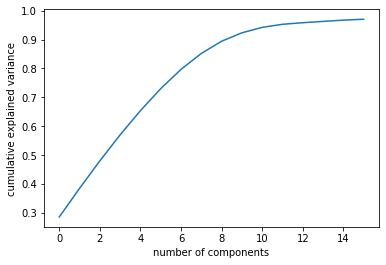

In [88]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

(87000, 93000)


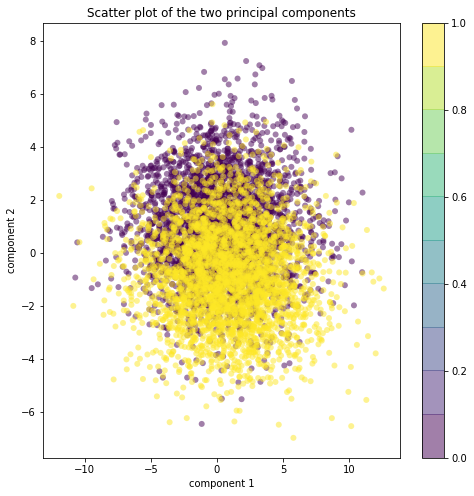

In [76]:
import matplotlib.cm as cm

plot_num = 3000
plot_range = (int(data_ana.shape[0]/2-plot_num),int(data_ana.shape[0]/2+plot_num))
print(plot_range)

plt.figure(figsize=(8,8))
plt.scatter(projected[plot_range[0]:plot_range[1], 0], projected[plot_range[0]:plot_range[1], 1],
            c=data_tar[plot_range[0]:plot_range[1]], edgecolor='none', alpha=0.5,
            cmap=cm.get_cmap('viridis', 10))
plt.title("Scatter plot of the two principal components")
plt.xlabel('component 1')
plt.ylabel('component 2')
#plt.xlim(-60,150)
#plt.ylim(-60,60)
plt.colorbar();


In [89]:
import sklearn 
numPCAcomp=4
container = list()
for k in range(len(data_comb_o)):
    sha = data_comb_o.shape
    pca = sklearn.decomposition.PCA(n_components=numPCAcomp)
    PCA = pca.fit(data_ana)
PCAembeddings = projected.transform(data_ana.reshape((-1,sha[2])))[:, 0:numPCAcomp].reshape((sha[0],sha[1],-1))
    container.append(PCAembeddings)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

In [77]:
ax=[]
fig,(ax) = plt.subplots(,4, figsize=(12,60))
for k,embed in enumerate(container):
    for i in range(numPCAcomp):
        pcolor = ax[k,i].pcolor(embed[:,:,i], cmap='viridis')
        ax[k,i].axis('scaled')
        ax[k,i].invert_yaxis()
        #pcolor.set_clim(0, 2)
        #fig.colorbar(pcolor)
        ax[k,i].set_title("spectra "+str(k)+", comp "+str(i))
#fig.suptitle("PCA Map - 4 components", fontsize=18)

NameError: name 'container' is not defined

## support vector classification (SVC) on PCA

In [246]:
X = projected
y = data_tar
y.shape

(180000,)

In [247]:
testx = np.concatenate([X[:50000],X[130000:]])
testy = np.concatenate([y[:50000],y[130000:]])
trainx = X[50000:130000]
trainy = y[50000:130000]

In [248]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
model = SVC()
model.fit(trainx, trainy)

predictions = model.predict(testx)
cm = confusion_matrix(testy,predictions)

/opt/anaconda/2019.07/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Text(0.5, 1, 'PCA Confusion Matrix')

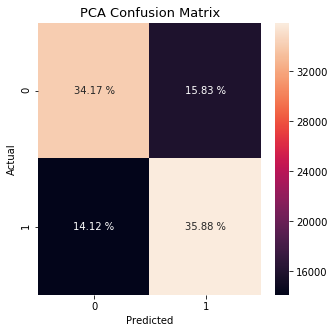

In [249]:
import seaborn as sn
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (5,5))
ax = sn.heatmap(df_cm, annot=True, fmt='.1f')
for t in ax.texts: t.set_text(str(round(int(float(t.get_text()))/predictions.shape[0]*100, 2)) + " %")
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title("PCA Confusion Matrix", fontsize=13)

### Trying out t-SNE

In [250]:
import time
from sklearn.manifold import TSNE

In [253]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=True, perplexity=50, n_iter=10000)
tsne_results = tsne.fit_transform(data_ana[plot_range[0]:plot_range[1]])

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.024s...
[t-SNE] Computed neighbors for 6000 samples in 4.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 1.735214
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.868134
[t-SNE] KL divergence after 1050 iterations: 2.535110
t-SNE done! Time elapsed: 318.979549407959 seconds


In [ ]:
tsne_results.shape

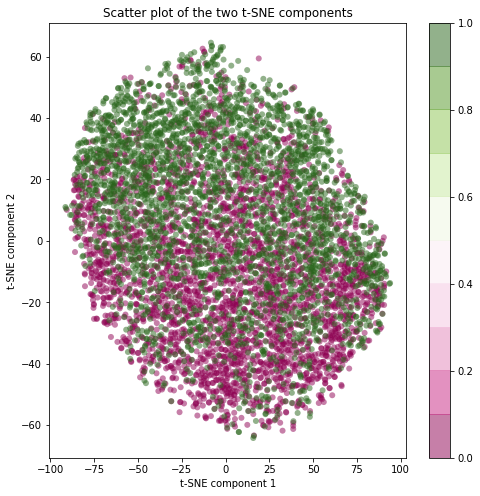

In [134]:
import matplotlib.cm as cm

plt.figure(figsize=(8,8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            c=data_tar[plot_range[0]:plot_range[1]], edgecolor='none', alpha=0.5,
            cmap=cm.get_cmap('PiYG', 10))
plt.title("Scatter plot of the two t-SNE components")
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar();


## support vector classification (SVC) on tsne

In [254]:
targett2 = data_tar[plot_range[0]:plot_range[1]]
X2 = tsne_results
y2 = targett2

In [255]:
testx2 = np.concatenate([X2[:2000],X2[4000:]])
testy2 = np.concatenate([y2[:2000],y2[4000:]])
trainx2 = X2[2000:4000]
trainy2 = y2[2000:4000]

In [256]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
model2 = SVC()
model2.fit(trainx2, trainy2)

predictions2 = model2.predict(testx2)
cm2 = confusion_matrix(testy2,predictions2)

/opt/anaconda/2019.07/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Text(0.5, 1, 't-SNE Confusion Matrix')

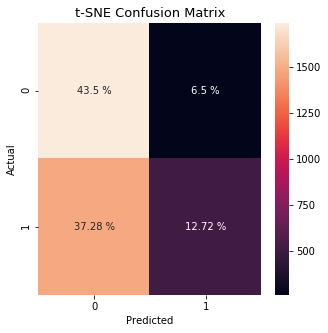

In [257]:
import seaborn as sn
df_cm2 = pd.DataFrame(cm2)
plt.figure(figsize = (5,5))
ax = sn.heatmap(df_cm2, annot=True, fmt='.1f')
for t in ax.texts: 
    t.set_text(str(round(int(float(t.get_text()))/predictions2.shape[0]*100, 2)) + " %")
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title("t-SNE Confusion Matrix", fontsize=13)

## support vector classification (SVC) on NMF

## Setup and run NMF 

In [260]:
numNMFcomp=4
NMFcomponents = list()
NMFembeddings = list()
for k in range(len(data_comb_o)):
    arrayx = np.array(data_comb_o[k])
    dim = arrayx.shape
    arrayx = arrayx.reshape((-1,dim[2]))
   
    # setup NMF 
    NMFmodel = sklearn.decomposition.NMF(n_components=numNMFcomp, 
                                     init='random',
                                     random_state=0, 
                                     alpha=1e-7, 
                                     l1_ratio=1)

    # computes NMF
    data_for_nmf = arrayx.reshape((-1,dim[2]))
    comp = NMFmodel.fit_transform(np.rollaxis(data_for_nmf - np.min(data_for_nmf), 1))
    comp = np.swapaxes(comp,0,1)

    emb = np.rollaxis(NMFmodel.components_, 1)
    emb = emb.reshape((dim[0],dim[1],numNMFcomp))
     
    NMFembeddings.append(emb)
    NMFcomponents.append(comp)

In [264]:
NMFembeddings = np.array(NMFembeddings)
NMFembeddings.shape

(20, 30, 300, 4)

In [ ]:
NMFcomponents.shape

In [265]:
X3 = projected
y3 = data_tar
y3.shape

(180000,)

In [267]:
testx3 = np.concatenate([X3[:50000],X3[130000:]])
testy3 = np.concatenate([y3[:50000],y3[130000:]])
trainx3 = X3[50000:130000]
trainy3 = y3[50000:130000]

In [268]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
model3 = SVC()
model3.fit(trainx3, trainy3)

predictions3 = model.predict(testx3)
cm3 = confusion_matrix(testy3,predictions3)


/opt/anaconda/2019.07/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


KeyboardInterrupt: 

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(cm3)
plt.figure(figsize = (5,5))
ax = sn.heatmap(df_cm, annot=True, fmt='.1f')
for t in ax.texts: t.set_text(str(round(int(float(t.get_text()))/predictions.shape[0]*100, 2)) + " %")
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title("NMF Confusion Matrix", fontsize=13)

## Setup and run ICA 

In [269]:
from sklearn.decomposition import PCA

In [270]:
print(data_target.shape)
print(data_comb_o.shape)

(20, 30, 300)
(20, 30, 300, 81)


In [271]:
data_ana = data_comb_o.reshape((-1,data_comb_o.shape[3]))
data_tar = data_target.reshape((-1))
print(data_ana.shape)
print(data_tar.shape)

(180000, 81)
(180000,)


In [277]:
numICAcomp = 16
ica = sklearn.decomposition.FastICA(n_components=numICAcomp, max_iter=2000, tol=0.01)
ICA = ica.fit_transform(data_ana)

In [287]:
X4 = ICA
y4 = data_tar
y4.shape

(180000,)

In [288]:
testx4 = np.concatenate([X4[:50000],X4[130000:]])
testy4 = np.concatenate([y4[:50000],y4[130000:]])
trainx4 = X4[50000:130000]
trainy4 = y4[50000:130000]

In [289]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
model4 = SVC()
model4.fit(trainx4, trainy4)

/opt/anaconda/2019.07/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [290]:
predictions4 = model4.predict(testx4)
cm4 = confusion_matrix(testy4,predictions4)

Text(0.5, 1, 'ICA Confusion Matrix')

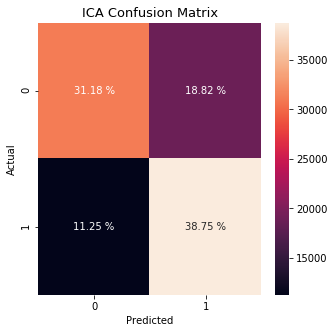

In [291]:
import seaborn as sn
df_cm = pd.DataFrame(cm4)
plt.figure(figsize = (5,5))
ax = sn.heatmap(df_cm, annot=True, fmt='.1f')
for t in ax.texts: t.set_text(str(round(int(float(t.get_text()))/predictions4.shape[0]*100, 2)) + " %")
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title("ICA Confusion Matrix", fontsize=13)

## Borrowed from the RNN Autoencoder code

In [ ]:
arrayx = data_ana
array_target = data_tar

In [ ]:
arrayx.shape

In [ ]:
array_target.shape

### Setting up RNN autoencoder

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, LeakyReLU
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Conv2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

In [ ]:
def rnn_autoencoder(layer, size, N_encode, 
                    N_decode, embed, 
                    N_steps, lr = 3e-6, drop_frac = 0.1,
                    bidir = False, l1_norm = 1e-4, **kwargs):
    """
    Function which builds the reccurrent neural network autoencoder
    
    Parameters
    ----------
    layer : string; options: 'lstm','gru'
        selects the layer type
    size  : numpy, int
        sets the size of encoding and decoding layers in the network
    N_encode  : numpy, int
        sets the number of encoding layers in the network
    N_decode : numpy, int
        sets the number of decoding layers in the network
    embed : numpy, int
        sets the size of the embedding layer
    N_steps : numpy, int
        length of the input time series
    lr : numpy, float
        sets the learning rate for the model
    drop_frac : numpy, float
        sets the dropout fraction
    bidir : numpy, bool
        selects if the model is linear or bidirectional
    l1_norm : numpy. float
        sets the lambda value of the l1 normalization. The larger the value the greater the
        sparsity. None can be passed to exclude the use or l1 normailzation.
    
    Returns
    -------
    model : Keras, object
        Keras tensorflow model
    """

    model = Sequential()
    
    
    
    # wrapper for bidirectional LSTM
    if bidir: wrapper = Bidirectional
    else: wrapper = lambda x: x
        
        
    # builds the first layer
    model.add(wrapper(layer(size, return_sequences=(N_encode > 1),  dropout=drop_frac, input_shape=(N_steps, 1))))

    # builds the encoding layers
    for i in range(1, N_encode):
        model.add(wrapper(layer(size, return_sequences=(i < N_encode - 1), dropout=drop_frac)))

    # builds the embedding layer
    model.add(Dense(embed, activation='relu', name='encoding', activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(N_steps))

    # builds the decoding layer
    for i in range(N_decode):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model

In [ ]:
def train_model(model, data_train, data_test, path, epochs, batch_size):
    """
    Function which trains the neural network
    
    Parameters
    ----------
    model : Keras, object
        model to train
    data_train  : numpy, float
        data to train the network
    data_test  : numpy, float
        data to test the network
    path : string
        sets the folder to save the data
    epochs : numpy, int
        train the network for this number of epochs
    batch_size : numpy, int
        sets the size of the batch. Batch size should be as large as possible. 
        It is however limited by the GPU memory.
    """

    #builds the filename
    filepath = path + '/weights.{epoch:02d}-{val_loss:.8f}.hdf5'
    
    # sets the control of checkpoints
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                                 verbose=0, save_best_only=True,
                                                 save_weights_only=True, 
                                                 mode='min', period=1)

    # fits the model
    model.fit(np.atleast_3d(data_train), np.atleast_3d(data_train), 
              epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], 
              validation_data=(np.atleast_3d(data_test), np.atleast_3d(data_test)))

In [ ]:
# construct a model
model3 = rnn_autoencoder(LSTM, 81, 3, 3, 9, 81)

In [ ]:
model3.summary()

### Training RNN Autoencoder

In [ ]:
# set learning rate and compile model
lr = 1e-5
model3.compile(Adam(lr), loss='mse')
folder_name = 'rnn_auto_deep2_checkpoints'

## Load model

In [ ]:
# load weights
model3.load_weights(folder_name+"/weights.99-0.10366738.hdf5")

# Compile model (required to make predictions)
lr = 5e-3
model3.compile(Adam(lr), loss='mse')

## Make Prediction

In [ ]:
test = arrayx[:]
test.shape

In [ ]:
predict = model3.predict(np.atleast_3d(test))

In [ ]:
predict.shape

In [ ]:
from sklearn import preprocessing
y1_norm = preprocessing.normalize(test)
y2_norm = preprocessing.normalize(predict.reshape(-1,81))
#y1_norm = test
#y2_norm = predict.reshape(-1,81)

In [ ]:
# Plotting Spectra Predictions (randomized for 36 spectra)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,2):
    for j in range(0,2):
        w = np.random.randint(0, y2_norm.shape[0])
        ax = axs[i,j]
        ax.plot(y1_norm[w], label="raw spectrum") 
        ax.plot(y2_norm[w], label="predict spectrum") 
        ax.legend(bbox_transform=ax.transAxes)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Spectra Prediction - RNN Autoencoder (LSTM, 81, 3, 3, 9, 81)"\
             "\n Labeled EELS data (anneal)", fontsize =18)

In [ ]:
def get_ith_layer_output(model, X, i, mode='test'):
    """
    Computes the activations of a specific layer
    see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'
    
    Parameters
    ----------
    model : keras model, object
        pre-trained keras model
    X  : numpy array, float
        Input data
    i  : numpy, int
        index of the layer to extract
    mode : string, optional
        test or train, changes the model behavior to scale the network properly when using
        dropout or batchnorm
        
    Returns
    -------
    layer_output : float
        array containing the output from layer i of the network
    """
    # computes the output of the ith layer
    get_ith_layer = backend.function([model.layers[0].input, 
                                            backend.learning_phase()], 
                                           [model.layers[i].output])
    layer_output = get_ith_layer([X, 0 if mode == 'test' else 1])[0]

    return layer_output

In [ ]:
activation = get_ith_layer_output(model3, np.atleast_3d(test), 3)

In [ ]:
activation.shape

In [ ]:
actv = activation.reshape(int(test.shape[0]/(20*300)),20,300,9)
fig, axs = plt.subplots(9, 1, figsize=(10, 10))
for k in range(9):
    ax = axs[k]
    ax.imshow(actv[0,:,:,k], cmap='viridis', interpolation='bilinear')
    #ax.pcolor(actv[0,:,:,k], cmap='viridis')
    ax.set_title(str(k+1), fontsize=28, color='white', loc='left', y=0.1, x=0.01)
fig.suptitle("Low dimensional Layer - RNN Autoencoder (LSTM, 81, 3, 3, 9, 81)"\
             " \n Labeled EELS data (initial)", fontsize=18)
plt.subplots_adjust(top=2.25)
plt.tight_layout()

In [ ]:
actv = activation.reshape(int(test.shape[0]/(20*300)),20,300,9)
fig, axs = plt.subplots(9, 1, figsize=(10, 10))
for k in range(9):
    ax = axs[k]
    ax.imshow(actv[3,:,:,k], cmap='viridis', interpolation='bilinear')
    #ax.pcolor(actv[3,:,:,k], cmap='viridis')
    ax.set_title(str(k+1), fontsize=28, color='white', loc='left', y=0.1, x=0.01)
fig.suptitle("Low dimensional Layer - RNN Autoencoder (LSTM, 81, 3, 3, 9, 81)"\
             " \n Labeled EELS data (anneal)", fontsize=18)
plt.subplots_adjust(top=2.25)
plt.tight_layout()

In [ ]:
# visualizing activation layer

import math

start = 387.5 #eV
stop = 851.25 #eV
step = 0.125 #eV

# Plotting aggregared spectra 
g,(ax3) = plt.subplots(1,1, figsize=(10,10))
for k in range(len(actv)):
    # Plotting aggregation over oxygen range
    ax3.plot(np.sum(actv[k][5:15,150:170], axis=(0,1)), color=(0.5*k/len(actv), 0.2*k/len(actv), 0.3*k/len(actv)), label="les")
    ax3.legend()
# plot configurations
g.suptitle('Pixel aggregation', fontsize=28)

ax3.set_title('Over O Peaks', fontsize=18)
ax3.set_xlabel('Energy Loss (eV)', fontsize=18)
ax3.set_ylabel('counts', fontsize=18)   

ax4.set_title('Over Fe Peaks', fontsize=18)
ax4.set_xlabel('Energy Loss (eV)', fontsize=18)
ax4.set_ylabel('counts', fontsize=18)  

In [ ]:
activation.shape

In [ ]:
import sklearn 
pca = sklearn.decomposition.PCA(9)  # project from N_resampled to 2 dimensions
projected = pca.fit_transform(activation)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
import matplotlib.cm as cm

plot_num = 5000
plot_range = (int(activation.shape[0]/2-plot_num),int(activation.shape[0]/2+plot_num))

plt.figure(figsize=(8,8))
plt.scatter(projected[plot_range[0]:plot_range[1], 0], projected[plot_range[0]:plot_range[1], 1],
            c=array_target.reshape((-1))[plot_range[0]:plot_range[1]], edgecolor='none', alpha=0.5,
            cmap=cm.get_cmap('viridis', 10))
plt.title("Scatter plot of the two principal components")
plt.xlabel('component 1')
plt.ylabel('component 2')
#plt.xlim(-60,150)
#plt.ylim(-60,60)
plt.colorbar();
